# Проект для «Викишоп»

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
import re

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import ADASYN
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from lightgbm import LGBMClassifier

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

RANDOM_STATE = 42

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
path1 = '/datasets/toxic_comments.csv'
path2 = 'C:/Users/Kseno/Downloads/toxic_comments.csv'

if os.path.exists(path1):
    comments = pd.read_csv(path1, index_col = 'Unnamed: 0')
elif os.path.exists(path2):
    comments = pd.read_csv(path2, index_col = 'Unnamed: 0')
else:
    print('Something is wrong')

pd.set_option('display.max_colwidth', None)
comments.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [4]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


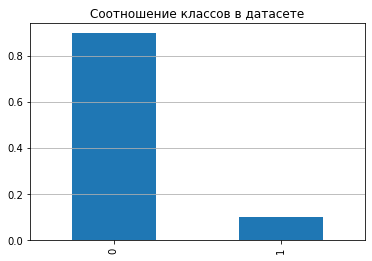

In [5]:
comments.toxic.value_counts(normalize=True).plot(kind='bar')
plt.title('Соотношение классов в датасете')
plt.grid(axis='y')
plt.show()

В датасете сильный дисбаланс классов: 90% положительных комментариев и 10% отрицательных. Для корректного обучения модели это нужно исправить.

In [6]:
# Создание датасета для экономии вычислительных ресурсов
dataset = comments.sample(50000, random_state=RANDOM_STATE).reset_index(drop=True)

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [8]:
# Функция для проставления частей речи
def get_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Функция для лемматизации и очистки текста
def clean_lemmatize(text):
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    pos_tags = nltk.pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)

In [9]:
dataset['lemm_text'] = dataset['text'].apply(clean_lemmatize)

In [10]:
dataset

,text,toxic,lemm_text
0,"Sometime back, I just happened to log on to www.izoom.in with a friend’s reference and I was amazed to see the concept Fresh Ideas Entertainment has come up with. So many deals… all under one roof. This website is very user friendly and easy to use and is fun to be on.\nYou have Gossip, Games, Facts… Another exciting feature to add to it is Face of the Week… Every week, 4 new faces are selected and put up as izoom faces. It’s great to have been selected in four out of a group of millions. \nThis new start up has already got many a deals in its kitty. Few of them being TheFortune Hotel, The Beach… are my personal favorites. izoom.in has a USP of mobile coupons. Coupons are available even when a user cannot access internet. You just need to SMS izoom support to 56767 and you get attended immediately.\nAll I can say is izoom.in is a must visit website for everyone before they go out for shopping or dining or for outing.\nCheers!!!",0,sometime back happen log www izoom friend reference amaze see concept fresh idea entertainment come many deal one roof website user friendly easy use fun gossip game facts another exciting feature add face week every week new face select put izoom face great select four group million new start already get many deal kitty thefortune hotel beach personal favorite izoom usp mobile coupon coupon available even user access internet need sm izoom support get attend immediately say izoom must visit website everyone go shop din out cheer
1,"""\n\nThe latest edit is much better, don't make this article state """"super."""" at all. 71.237.70.49 """,0,late edit much well make article state super
2,""" October 2007 (UTC)\n\nI would think you'd be able to get your point across, and be immune to any objections, were you to simply embellish the second sentence of the article by changing """"he was schooled at Thornleigh Salesian College"""" to """"he was schooled at (the then all-Catholic) Thornleigh Salesian College"""". \n\nGood suggestion from an Anon - what do you think? Rgds, - 07:53, 5""",0,october utc would think able get point across immune objection simply embellish second sentence article change school thornleigh salesian college school catholic thornleigh salesian college good suggestion anon think rgds
3,Thanks for the tip on the currency translation. Think it's all done now.,0,thanks tip currency translation think do
4,"I would argue that if content on the Con in comparison to the Arts Music is out of proportion, then it warrants further contribution to the article, not the removal of an indepth piece of content. Also, as I mentioned before, the Arts Music unit has a notable history comparable to that of the Con itself. Because of this, I would further argue that content on the Arts Music Unit is more relevant to this article than the information on the Newcastle Conservatorium.",0,would argue content con comparison art music proportion warrant contribution article removal indepth piece content also mention art music unit notable history comparable con would argue content art music unit relevant article information newcastle conservatorium
...,...,...,...
49995,Thanks for the advice. I tried and it did not work.,0,thanks advice try work
49996,"""\n\nI also like GPM's phrase, """"...Menzies' theories concerning early fifteenth century Chinese expeditions beyond the Cape of Good Hope to the Americas and Europe...""""\nRegarding the merger last year, I strongly objected to the removal of content, which was done without discussion, let alone consensus. I wrote at the time, """"A consensus to merge was NOT a consensus to mutilate the content of the articles discussing the books."""" """,0,also like gpm phrase menzies theory concern early fifteenth century chinese expedition beyond cape good hope america europe regard merger last year strongly object removal content do without discussion let alone consensus write time consensus merge consensus mutilate content article discuss book
49

## Обучение

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
    dataset['lemm_text'],
    dataset['toxic'],
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=dataset['toxic']
)

In [12]:
X_valid, X_test, y_valid, y_test = train_test_split(
    dataset['lemm_text'],
    dataset['toxic'],
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=dataset['toxic']
)

In [13]:
pipe_final = Pipeline(
    [
        ('tfidf', TfidfVectorizer()),
        ('adasyn', ADASYN(sampling_strategy='minority', random_state=RANDOM_STATE)),
        ('models', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
    ]
)

params = [
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': range(50, 55, 5),
        'models__max_depth': range(20, 25, 5)
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced'
        )]
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [200],
        'models__learning_rate': [0.1]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [2, 5, 10]
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'models__iterations': range(100, 200, 50),
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__max_depth': range(5, 7)
    }
]

In [14]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    params, 
    cv=3,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

In [15]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('adasyn',
                                              ADASYN(random_state=42,
                                                     sampling_strategy='minority')),
                                             ('models',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [RandomForestClassifier(class_weight='balanced',
                                                                           random_state=42)],
                                         'mod...
                                        {'models': [LGBMClassifier(random_state=42)],
                                         'models__learning_rate': [0.1],
                                         'models__n_estimators': [200]},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': [2, 5, 10]},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x7f706fa0efa0>],
                                         'models__iterations': range(100, 200, 50),
                                         'models__learning_rate': [0.01, 0.05,
                                                                   0.1],
                                         'models__max_depth': range(5, 7)}],
                   random_state=42, scoring='f1')

In [16]:
best_model = randomized_search.best_estimator_
'Лучшая модель и её параметры:', best_model

('Лучшая модель и её параметры:',
 Pipeline(steps=[('tfidf', TfidfVectorizer()),
                 ('adasyn',
                  ADASYN(random_state=42, sampling_strategy='minority')),
                 ('models', LGBMClassifier(n_estimators=200, random_state=42))]))

In [17]:
'Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_

('Метрика лучшей модели на кросс-валидации:', 0.7443253718379902)

In [18]:
y_pred = best_model.predict(X_test)

In [19]:
f'Метрика F1 на тестовой выборке: {f1_score(y_test, y_pred)}'

'Метрика F1 на тестовой выборке: 0.8116817724068479'

## Выводы

1. В датафрейме `comments` содержится 2 столбца и 159 292 строк.
2. Данные имеют сильный дисбаланс классов, 90% положительных комментариев и 10% отрицательных.
3. Для устранения дисбаланса классов было использовано сэмплирование ADASYN.
4. Для классификации комментариев на токсичность было обучено 5 моделей: `RandomForestClassifier`, `LogisticRegression`, `LGBMClassifier`, `KNeighborsClassifier`, `CatBoostClassifier`. 
5. Лучшей моделью оказалась `LGBMClassifier`.
6. Её метрика f1 на кросс-валидации 0.74, на тестовой выборке 0.81.